# Description

This notebook reads the performance data of a job (rdd_q5.py) from the `worker_comparison` directory and shows the evolution of the job execution time as the number of workers increases.

In [1]:
import pandas as pd
import glob

In [2]:

dfs = []
files = glob.glob('workers_comparison/*.csv')
print(files)
for file in files:
    df = pd.read_csv(file)
    # Drop the rows with the metrics jobs_records	tasks_records if they are present
    df = df[~df['metric'].str.contains('jobs_records|tasks_records')]
    # add first 10 characters of the filename as a column
    df['filename'] = file.split('/')[-1][:10]
    dfs.append(df)

['workers_comparison/rdd_q5_14.csv', 'workers_comparison/rdd_q5_3.csv', 'workers_comparison/rdd_q5_6.csv', 'workers_comparison/rdd_q5_9.csv']


In [3]:
# For each df change the reading_time & processing_time from seconds to a readable format (HH:MM:SS)
for df in dfs:
    mask = df['metric'].isin(['reading_time', 'processing_time'])
    df.loc[mask, 'value'] = pd.to_datetime(df.loc[mask, 'value'].astype(float), unit='s').dt.strftime('%H:%M:%S')

/tmp/ipykernel_359226/3734028902.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['00:00:02' '00:03:07']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'value'] = pd.to_datetime(df.loc[mask, 'value'].astype(float), unit='s').dt.strftime('%H:%M:%S')
/tmp/ipykernel_359226/3734028902.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['00:00:01' '00:07:00']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'value'] = pd.to_datetime(df.loc[mask, 'value'].astype(float), unit='s').dt.strftime('%H:%M:%S')
/tmp/ipykernel_359226/3734028902.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['00:00:01' '00:05:35']' has dtype incompati

In [4]:
def format_records(value):
    num = int(value)
    if num >= 1_000_000:
        return f'{num / 1_000_000:.1f}M'
    elif num >= 1_000:
        return f'{num / 1_000:.1f}k'
    else:
        return str(num)

for df in dfs:
    mask = df['metric'].str.endswith('_records')
    df.loc[mask, 'value'] = df.loc[mask, 'value'].apply(format_records)

In [5]:
# Initialize an empty list to hold the processed data
rows = []

# Process each dataframe
for idx, df in enumerate(dfs):
    # Extract the question ID (e.g., q1, q2, ...)
    question_id = f'Question {idx + 1}'
    # Convert the dataframe to a dictionary of metrics and add the question ID
    row = {row['metric']: row['value'] for _, row in df.iterrows()}
    row['filename'] = df['filename'].iloc[0]
    rows.append(row)

# Create a dataframe from the list of rows
combined_df = pd.DataFrame(rows)

# Fill missing values with a placeholder (e.g., '-')
combined_df = combined_df.fillna('-')



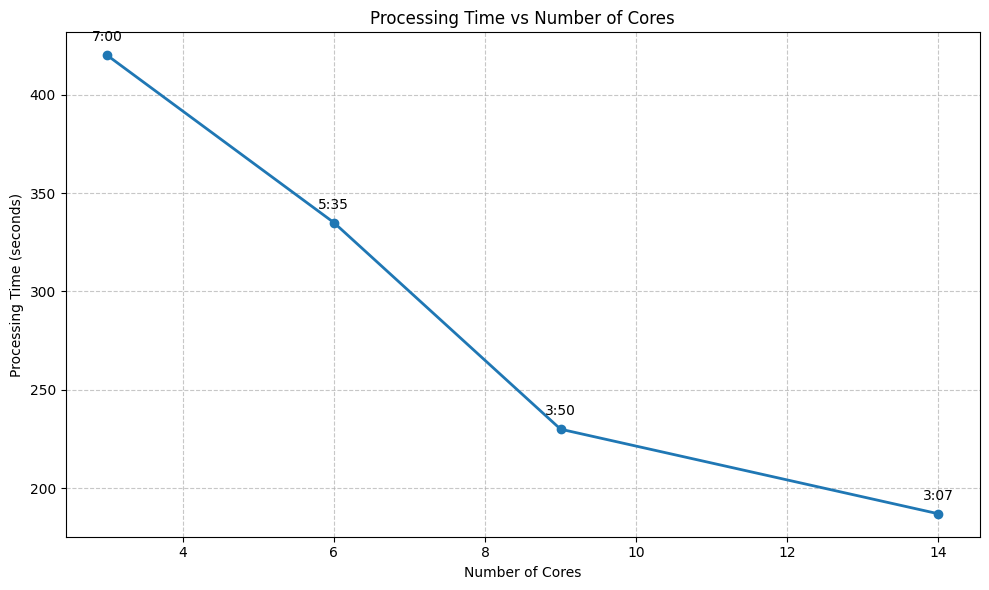

In [6]:
from matplotlib import pyplot as plt
import re

def extract_cores(filename):
    """Extract the number of cores from the filename."""
    match = re.search(r'q5_(\d+)', filename)
    return int(match.group(1)) if match else None

def time_to_seconds(time_str):
    """Convert time string in format HH:MM:SS to total seconds."""
    hours, minutes, seconds = map(int, time_str.split(':'))
    return hours * 3600 + minutes * 60 + seconds

# Extract cores and convert times to seconds
combined_df['cores'] = combined_df['filename'].apply(extract_cores)
combined_df['processing_seconds'] = combined_df['processing_time'].apply(time_to_seconds)

# Sort by number of cores
combined_df = combined_df.sort_values('cores')

# Create the visualization
plt.figure(figsize=(10, 6))
plt.plot(combined_df['cores'], combined_df['processing_seconds'], marker='o', linestyle='-', linewidth=2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of Cores')
plt.ylabel('Processing Time (seconds)')
plt.title('Processing Time vs Number of Cores')

# Add data labels
for x, y in zip(combined_df['cores'], combined_df['processing_seconds']):
    minutes = int(y // 60)
    seconds = int(y % 60)
    plt.annotate(f'{minutes}:{seconds:02d}', 
                (x, y), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

# Improve the plot appearance
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
# Sort by processing_time
combined_df.sort_values(by='processing_time', inplace=True)
combined_df.head(10)

,reading_time,processing_time,total_records,filename,cores,processing_seconds
0,00:00:02,00:03:07,144.7M,rdd_q5_14.,14,187
3,00:00:01,00:03:50,144.7M,rdd_q5_9.c,9,230
2,00:00:01,00:05:35,144.7M,rdd_q5_6.c,6,335
1,00:00:01,00:07:00,144.7M,rdd_q5_3.c,3,420


# Conclusion

We can clearly see how the number of workers impact the execution time: the more workers, the faster the execution. However, the speedup is not linear, as the overhead of creating and managing the workers is not negligible.